## Demonstration: Predicting Employee Churn 
Prepared by Nick Freeman, PhD

This notebook considers the problem of predicting employee churn for the purpose of demonstrating several machine learning techniques in Python. Employee churn refers to the turnover in an organization's staff as existing employees leave and new ones are hired. The churn rate is typically calculates as the percent of employees leaving the company over some specified time period. Although some staff turnover is inevitable, a high rate of churn is costly because of the associated costs of hiring and training. Moreover, it can take several months for a new hire to acclimate to a new position, and longer before the company realizes any return on their hiring investments. If an organization can predict the attributes that may cause an employee to leave, interventions may be planned to reduce churn.

The following code block imports some libraries that we will use for our analysis.

In [1]:
import pandas as pd 

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from ipywidgets import interact

We assume that the company has historical data that was gathered from employee surveys. The data (which was modified from that used in the tutorial available at https://www.datacamp.com/community/tutorials/predicting-employee-churn-python) includes the following fields:

- `satisfaction_level`: the employee's reported satisfaction with their job (ranges from 0 to 100),
- `last_evaluation`: the employee's last performance evaluation score, (ranges from 0 to 100),
- `number_of_projects`: the number of projects assigned to the employee,
- `average_monthly_hours`: average number of hours worked by the employee during a month,
- `years_with_company`: the number of years the employee has been with the company,
- `involved_in_accident`: 0 or 1 (no or yes) to indicate whether or not the employee has been involved in an accident at work,
- `promoted_last_5_years`: 0 or 1 (no or yes) to indicate whether or not the employee was promoted within the lat 5 years,
- `department`: the employee's working department/division.
- `salary_level`: the employee's salary level (low, medium, or high),
- `left_company`: 0 or 1 (no or yes) to indicate whether or not the employee left the company.

The following code block reads in the data, stores the data in a Pandas `DataFrame` object named `data`, and prints the first 5 rows of the `data` object.

In [2]:
data = pd.read_csv('data/HR_comma_sep.csv')
data.head()

,satisfaction_level,last_evaluation,number_of_projects,average_monthly_hours,years_with_company,involved_in_accident,left_company,promoted_last_5_years,department,salary_level
0,38.0,49.0,2,137,3,0,1,0,technical,medium
1,86.0,92.0,5,137,3,0,0,0,technical,medium
2,70.0,87.0,5,239,3,0,0,0,hr,medium
3,38.0,56.0,2,156,3,0,1,0,technical,low
4,81.0,77.0,3,221,2,0,0,0,technical,low


The following code block uses Pandas `info()` method to provide information on the number and types of information included in each column of the dataset.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_of_projects       14999 non-null int64
average_monthly_hours    14999 non-null int64
years_with_company       14999 non-null int64
involved_in_accident     14999 non-null int64
left_company             14999 non-null int64
promoted_last_5_years    14999 non-null int64
department               14999 non-null object
salary_level             14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


The output shows that the dataset has 14,999 instances (or samples) and 10 attributes (or features), 6 integer, 2 float, and 2 objects. No variable column has null/missing values. 

We are interested in developing models that can correctly predict values in the `left_company` column. The following code block uses Pandas `groupby` method to find the mean values of the numeric attributes for employees that have either left or stayed with the company.

In [4]:
data.groupby('left_company').mean()

,satisfaction_level,last_evaluation,number_of_projects,average_monthly_hours,years_with_company,involved_in_accident,promoted_last_5_years
left_company,,,,,,,
0,66.680959,71.547340,3.786664,199.060203,3.380032,0.175009,0.026251
1,44.009801,71.811257,3.855503,207.419210,3.876505,0.047326,0.005321


The previous output suggests that employees that leave the company had a lower mean satisfaction level, worked more hours each month, on average, and had a lower promotion rate. However, they were also less likely to be involved in an accident and are similar to employees that stayed with the comapny in terms of number of projects and years with the company. 

The following code block defines an interactive plot that allows you to easily investigate differences in the number of employees that stay or leave as the various attributes vary.

In [5]:
attribute_columns = ['satisfaction_level', 'last_evaluation', 'number_of_projects',
                     'average_monthly_hours', 'years_with_company', 'involved_in_accident', 'promoted_last_5_years', 'department', 'salary_level']

@interact(attribute = attribute_columns)

def interactive_spend_analysis(attribute = attribute_columns[0]):
    
    data_copy = data.copy()
    data_copy['satisfaction_level'] = pd.cut(data_copy['satisfaction_level'], [i*10 for i in range(11)])
    data_copy['last_evaluation'] = pd.cut(data_copy['last_evaluation'], [i*10 for i in range(11)])
    data_copy['average_monthly_hours'] = pd.cut(data_copy['average_monthly_hours'], [i*25 for i in range(3,14)])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.countplot(x = attribute, 
                  data = data_copy, 
                  hue = 'left_company', 
                  ax = ax,
                  edgecolor = 'k')
    plt.xticks(rotation = 45, fontsize = 14)
    plt.yticks(fontsize = 14)
    ax.set_xlabel(attribute, fontsize = 16)
    ax.set_ylabel('Count', fontsize = 16)
    plt.legend(title ='left_company',fontsize = 16)
    
    plt.show()

interactive(children=(Dropdown(description='attribute', options=('satisfaction_level', 'last_evaluation', 'num…

We will now turn our attention to preparing the data for our machine learning analysis. The machine learning algorithms that we will consider require numerical input data. Therefore, we need to develop a numerical representation for the categorical data contained in the `department` and `salary_level` columns. The following code block uses Pandas `get_dummies()` method for `DataFrame` objects to generate a binary representation for the `department` column. This conversion is commonly referred to as *one hot encoding*.

In [6]:
pd.get_dummies(data['department'])

,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,0,0,0,1,0
7,0,0,0,0,1,0,0,0,0,0
8,0,0,0,0,0,0,1,0,0,0
9,0,0,0,0,0,0,0,1,0,0


The following code block uses Pandas `get_dummies()` method for `DataFrame` objects to generate a binary representation for the `department` and `salary_level` columns. This conversion is commonly referred to as *one hot encoding*.

In [7]:
data = pd.concat([data, pd.get_dummies(data['department'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['salary_level'])], axis=1)
data.head()

,satisfaction_level,last_evaluation,number_of_projects,average_monthly_hours,years_with_company,involved_in_accident,left_company,promoted_last_5_years,department,salary_level,...,hr,management,marketing,product_mng,sales,support,technical,high,low,medium
0,38.0,49.0,2,137,3,0,1,0,technical,medium,...,0,0,0,0,0,0,1,0,0,1
1,86.0,92.0,5,137,3,0,0,0,technical,medium,...,0,0,0,0,0,0,1,0,0,1
2,70.0,87.0,5,239,3,0,0,0,hr,medium,...,1,0,0,0,0,0,0,0,0,1
3,38.0,56.0,2,156,3,0,1,0,technical,low,...,0,0,0,0,0,0,1,0,1,0
4,81.0,77.0,3,221,2,0,0,0,technical,low,...,0,0,0,0,0,0,1,0,1,0


The following code block renames the columns.

In [8]:
data.columns = ['satisfaction_level', 'last_evaluation', 'number_of_projects',
                'average_monthly_hours', 'years_with_company', 'involved_in_accident',
                'left_company', 'promoted_last_5_years', 'department', 'salary_level',
                'IT', 'RandD', 'accounting', 'hr', 'management', 'marketing',
                'product_mng', 'sales', 'support', 'technical', 
                'salary_high', 'salary_low', 'salary_medium']

data.head()

,satisfaction_level,last_evaluation,number_of_projects,average_monthly_hours,years_with_company,involved_in_accident,left_company,promoted_last_5_years,department,salary_level,...,hr,management,marketing,product_mng,sales,support,technical,salary_high,salary_low,salary_medium
0,38.0,49.0,2,137,3,0,1,0,technical,medium,...,0,0,0,0,0,0,1,0,0,1
1,86.0,92.0,5,137,3,0,0,0,technical,medium,...,0,0,0,0,0,0,1,0,0,1
2,70.0,87.0,5,239,3,0,0,0,hr,medium,...,1,0,0,0,0,0,0,0,0,1
3,38.0,56.0,2,156,3,0,1,0,technical,low,...,0,0,0,0,0,0,1,0,1,0
4,81.0,77.0,3,221,2,0,0,0,technical,low,...,0,0,0,0,0,0,1,0,1,0


The following code block specifies the set of columns in the `data` object that we will pass to our machine learning algorithms as features. The machine learning algorithms that we consider will attempt to learn patterns of these features that explain variation in the target variable, which for our problem is the value in the `left_company` column.

In [9]:
features = ['satisfaction_level', 'last_evaluation', 'number_of_projects',
            'average_monthly_hours', 'years_with_company', 'involved_in_accident',
            'promoted_last_5_years', 'IT', 'RandD', 'accounting', 
            'hr', 'management', 'marketing', 'product_mng', 'sales', 'support', 'technical',
            'salary_high', 'salary_low', 'salary_medium']

target = 'left_company'

X = data[features]
y = data[target]

The following code block splits the dataset into two parts, training and testing datasets. The machine learning algorithms will use the training dataset when learning the patterns of features that affect the target. The testing dataset will be used to investigate the accuracy of the learned models. We specify that 70% of the data be used for training and the remianing 30% be used for testing.

In [10]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% training and 30% test

# Logistic Regression

In this section, we show how to define a logistic regression model for our prediction problem. In statistics, the logistic model (or logit model) is a widely used statistical model that uses a logistic function to model a binary dependent variable; many more complex extensions exist. A binary logistic model has a dependent variable with two possible values, such as pass/fail, win/lose, alive/dead or healthy/sick; these are represented by an indicator variable, where the two values are labeled "0" and "1". In the logistic model, the log-odds (the logarithm of the odds) for the value labeled "1" is a linear combination of one or more independent variables ("predictors"); the independent variables can each be a binary variable (two classes, coded by an indicator variable) or a continuous variable (any real value). The corresponding probability of the value labeled "1" can vary between 0 (certainly the value "0") and 1 (certainly the value "1"), hence the labeling; the function that converts log-odds to probability is the logistic function, hence the name.

The following code block uses the scikit-learn package to define a logistic regression model, fit the model to our training data, and use the fitted model to make predictions for the instances included in the testing dataset.

In [11]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver = 'newton-cg')
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
score = clf.score(X_test, y_test)
print(f'The logistic regression model achieves an accuracy of {np.round(100*score, 2)}%')

The logistic regression model achieves an accuracy of 78.69%


The output of the previous code block suggests that the logistic regression model is able to correctly predict whether or not an employee will leave for approximately 78.62% of the test instances. 

The following code block defines a function for generating a confusion matrix for the predictions. The cofusion matric provides additional information regarding the type of errors made by a machine learning model (i.e., false positives or false negatives).

In [12]:
def plot_confusion_matrix(cm):
    
    f, ax = plt.subplots(figsize=(8, 8))

    ax = sns.heatmap(cm, annot=True,
                     fmt=".0f", 
                     square = True,
                     linecolor='k',
                     annot_kws={"size": 20})
    for _, spine in ax.spines.items():
        spine.set_visible(True)

    plt.xticks(fontsize = 18)    
    plt.yticks(fontsize = 18) 
    plt.ylabel('left_job actual', fontsize = 18);
    plt.xlabel('left_job predicted', fontsize = 18);
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize = 14)
    plt.show()

The following code block uses our function to generate the confusion matrix for the logistic regression model. 

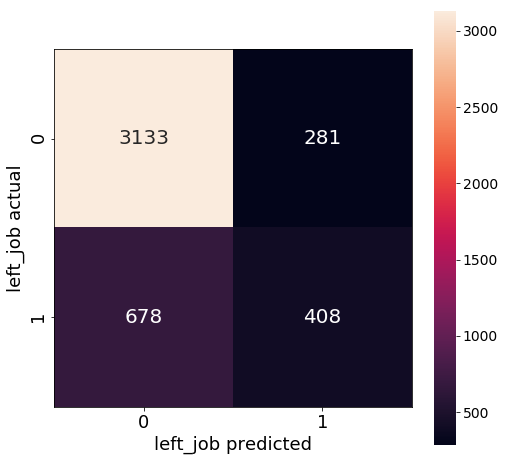

In [13]:
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, predictions)

plot_confusion_matrix(cm)

 The following plot uses the `coef_` attribute of the model to show how the model features influence the prediction (positive numbers suggest that increasing values of the feature contibute to employee churn).

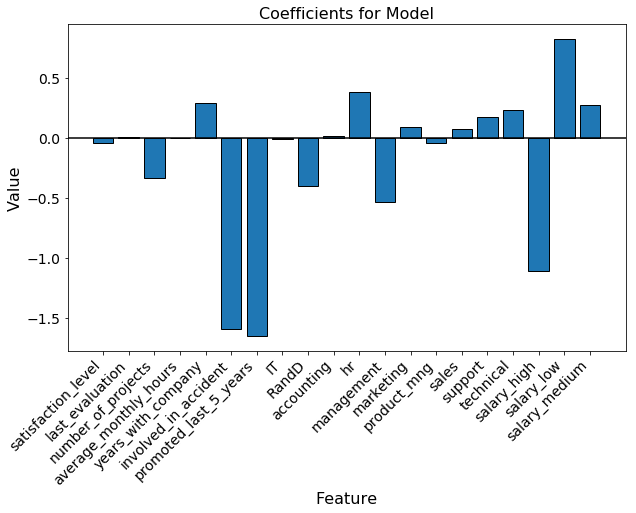

In [14]:
x_vals = [i for i in range(len(clf.coef_.flatten()))]

fig, ax = plt.subplots(figsize = (10,6))

ax.bar(x_vals, clf.coef_.flatten(), edgecolor = 'k')
ax.set_xticks(x_vals)
ax.set_xticklabels(features, ha='right') 
    
plt.xticks(rotation = 45, fontsize = 14)
plt.yticks(fontsize = 14)
ax.set_xlabel('Feature', fontsize = 16)
ax.set_ylabel('Value', fontsize = 16)
ax.axhline(0, color = 'k')
ax.set_title('Coefficients for Model', fontsize = 16)

plt.show()

# Decision Tree

Decision Tree models divide the feature space into sub-parts by identifying threshold feature values that result in good separation of the target variable for training instances. The following code block defines a decision tree model, fits the model to the training data, and uses the fitted model to predict the target variable for the instances in the testing dataset.

In [15]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
score = clf.score(X_test, y_test)
print(f'The decision tree model achieves an accuracy of {np.round(100*score, 2)}%')

The decision tree model achieves an accuracy of 97.84%


The decision tree model offers a dramatic improvement in accuracy when compared to the logistic regression model. In particular, the decision tree model offers an accuracy improvement of nearly 20%, correctly predicting whether or not an employee leaves for approximately 97.5% of the test instances. The confusion matrix for the decision tree predictions follows.

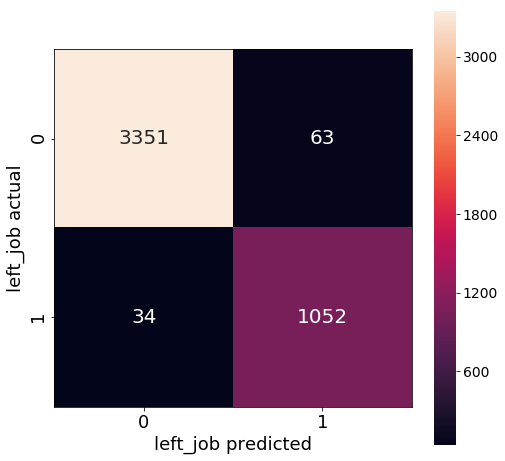

In [16]:
cm = metrics.confusion_matrix(y_test, predictions)

plot_confusion_matrix(cm)

The confusion matrix shows the nature of the improvements in prediction. Of particular interest, we note that the decision tree model only makes 43 incorrect predictions on the 1,072 instances where the associated employee actually left the company. The following plot uses the `feature_importances_` attribute of the model to show which features have the larget impact on the classification.

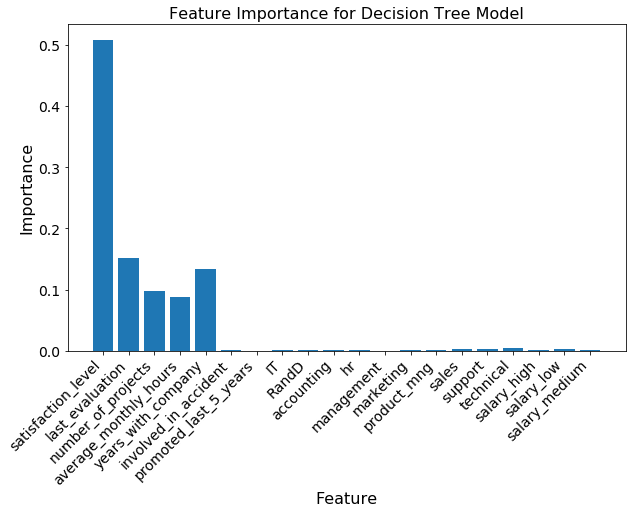

In [17]:
x_vals = [i for i in range(len(clf.feature_importances_))]

fig, ax = plt.subplots(figsize = (10,6))

ax.bar(x_vals, clf.feature_importances_)
ax.set_xticks(x_vals)
ax.set_xticklabels(features, ha='right') 
    
plt.xticks(rotation = 45, fontsize = 14)
plt.yticks(fontsize = 14)
ax.set_xlabel('Feature', fontsize = 16)
ax.set_ylabel('Importance', fontsize = 16)
ax.set_title('Feature Importance for Decision Tree Model', fontsize = 16)

plt.show()

# Random Forest

In this section, we consider a random forest classification model. Random forests construct a specified number of decision trees and outputs the mode class of the individual trees. By *ensembling* several decision trees, random forests are *largely immune* to overfitting. The following code block defines a random forest model that consists of 100 decision trees, fits the model to the training data, and uses the fitted model to predict the target variable for the instances in the testing dataset.

In [18]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 100, random_state=0)
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
score = clf.score(X_test, y_test)
print(f'The logistic regression model achieves an accuracy of {np.round(100*score, 2)}%')

The logistic regression model achieves an accuracy of 99.04%


The following code block prints the confusion matrix for the random forest model.

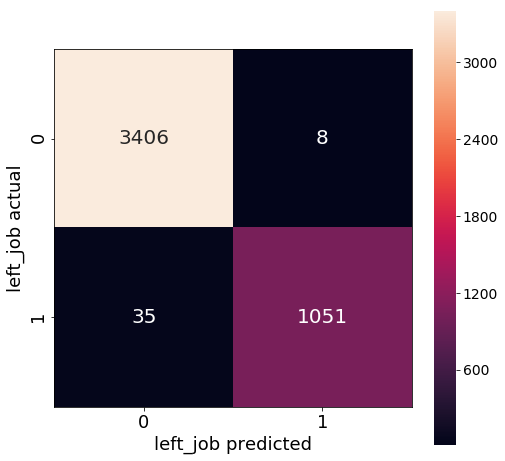

In [19]:
cm = metrics.confusion_matrix(y_test, predictions)

plot_confusion_matrix(cm)

The following plot uses the `feature_importances_` attribute of the model to show which features have the larget impact on the classification.

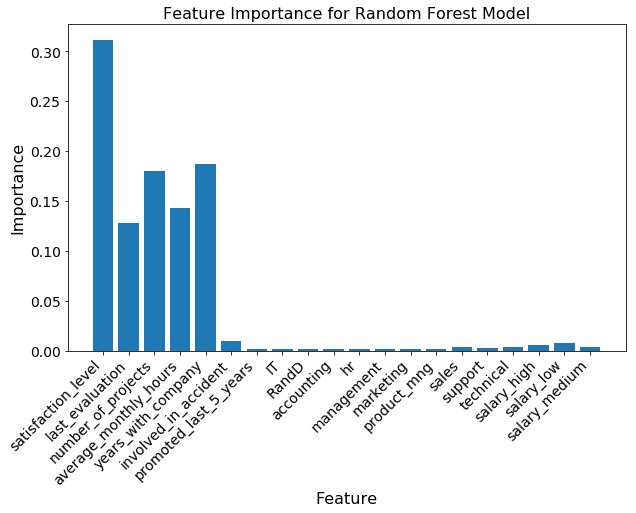

In [20]:
x_vals = [i for i in range(len(clf.feature_importances_))]

fig, ax = plt.subplots(figsize = (10,6))

ax.bar(x_vals, clf.feature_importances_)
ax.set_xticks(x_vals)
ax.set_xticklabels(features, ha='right') 
#for tick in ax.get_xticklabels():
#    tick.set_rotation(60)
    
plt.xticks(rotation = 45, fontsize = 14)
plt.yticks(fontsize = 14)
ax.set_xlabel('Feature', fontsize = 16)
ax.set_ylabel('Importance', fontsize = 16)
ax.set_title('Feature Importance for Random Forest Model', fontsize = 16)

plt.show()